## Remote Sensing Passive vs. Active

To have your deep learning models perform properly in noisy environments as an essential step it is critical to understand what is the noise grade in the target environment. This will allow your system to decide how to behave according to the existing noise.

In this notebook I describe how to grade the effects in the environment using cameras (as passive sensors). However, the technique is applicable to activate sensor data as well.  
Next, I will show how to use this information to manage the deep learning models on a device in real-time more effectively to keep the object detection/classification accuracy as high as possible.

<div>
<img src="./img/Passive_Activate.jpg" width="450" height="400" align=Right />
<p>In this notebook you will see the following:</p>
    
<ul>
  <li>Use numpy built-in FFT to transform images to frequency domain. </li>
  <li>Use numpy built-in fftShift to shift the low/high frequency components. </li>
  <li>use numpy built-in inverse FFT to reconstruct the shifted images.</li>
  <li>Observe the difference and grade the noise in the environment accordingly.</li>    
</ul>  
    
<img src="./img/FFT.png" width="300" height="200" align=Left />
          
</div>



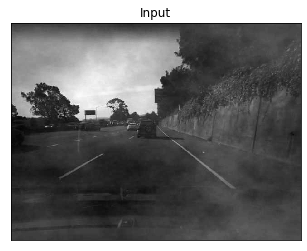

In [190]:
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import argparse
import imutils
import cv2

# use the following test images to understand the process better  
#orig = cv2.imread('./img/original/0001.jpg')
orig = cv2.imread('./img/augmented/0009.jpg')
image = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)

# display the original input image
(fig, ax) = plt.subplots(1, 1, )
ax.imshow(image, cmap="gray")
ax.set_title("Input")
ax.set_xticks([])
ax.set_yticks([])
plt.show()    

mean: 127.9525361146401


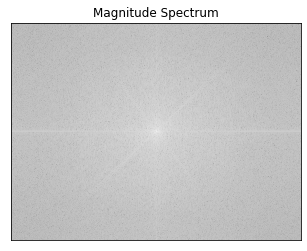

In [191]:
(h, w) = image.shape
(cX, cY) = (int(w / 2.0), int(h / 2.0))

# Using numpy built-in FFT to transform the image to frequency domain
# and use fftshift to shift zero frequency components to the center  
fft = np.fft.fft2(image)
fftShift = np.fft.fftshift(fft)   

magnitude = 20 * np.log(np.abs(fftShift))
mean = np.mean(magnitude)
print("mean: {}".format(mean))

(fig, ax) = plt.subplots(1, 1, )
ax.imshow(magnitude, cmap="gray")
ax.set_title("Magnitude Spectrum")
ax.set_xticks([])
ax.set_yticks([])
plt.show()    

mean: -7.76680999777422


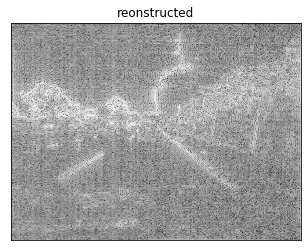

In [192]:
# Reconstruct the transformed image
size = 60
thresh=0
# zero out the center to remove lower frequencies
# next use inverse fft to reconstruct the image
fftShift[cY - size:cY + size, cX - size:cX + size] = 0
fftShift = np.fft.ifftshift(fftShift)
recon = np.fft.ifft2(fftShift)

magnitude = 20 * np.log(np.abs(recon))
mean = np.mean(magnitude)
print("mean: {}".format(mean))


(fig, ax) = plt.subplots(1, 1, )
ax.imshow(magnitude, cmap="gray")
ax.set_title("reonstructed")
ax.set_xticks([])
ax.set_yticks([])
plt.show()    

In [200]:
# annotate image based on w/ fog or w/o fog
foggy = mean <= thresh
image = np.dstack([gray] * 3)

fog_grade = {range(thresh - 10, thresh): '0',
             range(thresh - 20,thresh - 10): '1',
             range(thresh - 30, thresh - 20): '2',
             range(thresh - 100, thresh - 30): '3'
            }

color = (0, 0, 255) if foggy else (0, 255, 0)
            
            
if foggy:
    text = "w Fog (grade: {})"
    for key in fog_grade:
        if int(mean) in key:
            break
    text = text.format(fog_grade[key])
else:
    text = "w/o Fog ({:.4f})"
    text = text.format(mean)
    
    
cv2.putText(image, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7,color, 2)
print("[INFO] {}".format(text))

[INFO] w Fog (grade: 0)


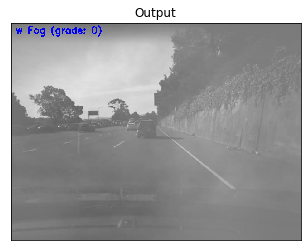

In [201]:
# Plot the annotated output image 
(fig, ax) = plt.subplots(1, 1, )
ax.imshow(image, cmap="gray")
ax.set_title("Output")
ax.set_xticks([])
ax.set_yticks([])
plt.show()    